In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [10]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA

In [11]:
adata = sc.read_h5ad('../datasets/02_dex_annotated_cd8_mvTCR_concat.h5ad')
adata

AnnData object with n_obs × n_vars = 44310 × 10
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu.C

In [12]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [13]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_umap"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
P1_clones = adata[P1_mask].obs["clone_id"].values
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [14]:
from sklearn.model_selection import train_test_split

# Extract unique clonotypes from P1
unique_clonotypes_aggregated = np.unique(P1_clones)

# Train-test split by unique clonotypes
train_clonotypes, test_clonotypes = train_test_split(unique_clonotypes_aggregated, test_size=0.2, random_state=42)

# Create masks for train and test sets based on the asigned clonotypes
train_mask = np.isin(unique_clonotypes_aggregated, train_clonotypes)
test_mask = np.isin(unique_clonotypes_aggregated, test_clonotypes)

# Recreate aggregated arrays aligned with unique clonotypes
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []


# Aggregate features and targets by clone
for clone in unique_clonotypes_aggregated:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1[mask].mean())      # Mean of y_s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of y_t1 for the clone

# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)


# Split aggregated data into train and test sets
X_train, X_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train a model for S1 using Linear Regression
model_s1 = LinearRegression()
model_s1.fit(X_train, y_s1_train)
y1_pred = model_s1.predict(X_test)

# Train a model for T1 using Linear Regression
model_t1 = LinearRegression()
model_t1.fit(X_train, y_t1_train)
y2_pred = model_t1.predict(X_test)

In [16]:
# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y1_pred)
r2_s1 = r2_score(y_s1_test, y1_pred)  # R² Score
correlation_s1 = np.corrcoef(y_s1_test, y1_pred)[0, 1]  # Correlation coefficient as an inference score

print(f"MSE for S1 (Linear Regression): {mse_s1}")
print(f"R² for S1: {r2_s1}")
print(f"Inference Score (Correlation) for S1: {correlation_s1}")

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y2_pred)
r2_t1 = r2_score(y_t1_test, y2_pred)  # R² Score
correlation_t1 = np.corrcoef(y_t1_test, y2_pred)[0, 1]  # Correlation coefficient as an inference score

print(f"MSE for T1 (Linear Regression): {mse_t1}")
print(f"R² for T1: {r2_t1}")
print(f"Inference Score (Correlation) for T1: {correlation_t1}")


MSE for S1 (Linear Regression): 0.054233203814437345
R² for S1: 0.021485093791173915
Inference Score (Correlation) for S1: 0.19347177126154258
MSE for T1 (Linear Regression): 0.10554171892892858
R² for T1: 0.10625947138227554
Inference Score (Correlation) for T1: 0.3302449632498973


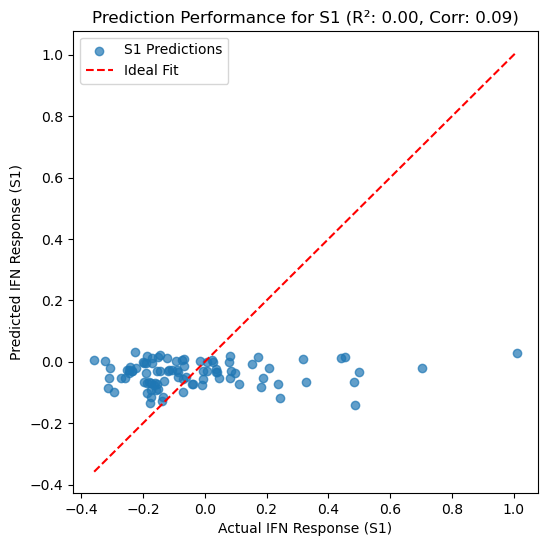

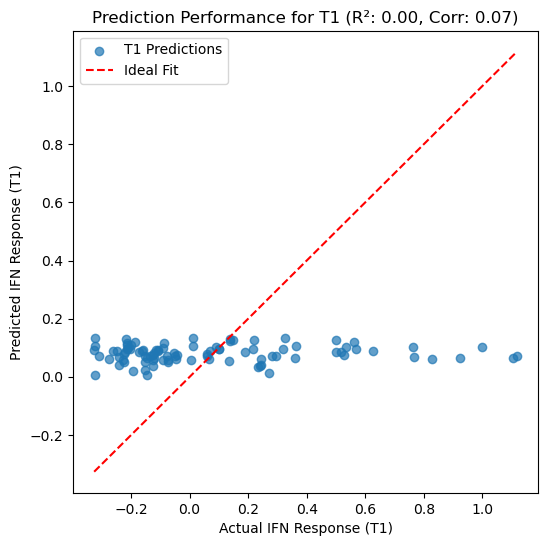

In [8]:
import matplotlib.pyplot as plt

# Visualization for S1
plt.figure(figsize=(6, 6))
plt.scatter(y_s1_test, y1_pred, alpha=0.7, label="S1 Predictions")
plt.plot([y_s1_test.min(), y_s1_test.max()], [y_s1_test.min(), y_s1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (S1)")
plt.ylabel("Predicted IFN Response (S1)")
plt.title(f"Prediction Performance for S1 (R²: {r2_s1:.2f}, Corr: {correlation_s1:.2f})")
plt.legend()
plt.show()

# Visualization for T1
plt.figure(figsize=(6, 6))
plt.scatter(y_t1_test, y2_pred, alpha=0.7, label="T1 Predictions")
plt.plot([y_t1_test.min(), y_t1_test.max()], [y_t1_test.min(), y_t1_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual IFN Response (T1)")
plt.ylabel("Predicted IFN Response (T1)")
plt.title(f"Prediction Performance for T1 (R²: {r2_t1:.2f}, Corr: {correlation_t1:.2f})")
plt.legend()
plt.show()
